In [1]:
import os
os.chdir("..")

import torch
from data.dataloader import dl_from_numpy
from models.predictor import GRU
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt

from data.dataloader import dataloader_info
from utils.utils import load_yaml_config



/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
configs = load_yaml_config("configs/stock.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

# dataloader
dl_info_train = dataloader_info(configs)
dl_info_test = dataloader_info(configs, train=False)
dataset = dl_info_train['dataset']
seq_length, feature_dim = dataset.window, dataset.feature_dim
batch_size = configs["dataloader"]["batch_size"]
lr = 0.001

In [3]:
ori_dl = dl_from_numpy(os.path.join(dataset.dir, f"stock_ground_truth_{seq_length}_train.npy"), batch_size=batch_size)
fake_dl = dl_from_numpy(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"), batch_size=batch_size)

In [4]:
# train on the fake
model_fake = GRU(hidden_dim=50, num_layers=2)
criterion_fake = nn.MSELoss()
optimizer_fake = optim.Adam(model_fake.parameters(), lr=lr)

model_fake.train()
with tqdm(range(100), total=100) as pbar:
    for e in pbar:
        for data in fake_dl:
            x_train = data[:,:23,:].float()
            y_train = data[:,23, 0].view(-1,1).float()
            
            optimizer_fake.zero_grad()
            outputs = model_fake(x_train)
            loss = criterion_fake(outputs, y_train)
            loss.backward()
            optimizer_fake.step()
        pbar.set_description(f"loss : {loss.item():.6f}")


loss : 0.006412: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


In [5]:
# train on the original
model_ori = GRU(hidden_dim=50, num_layers=2)
criterion_ori = nn.MSELoss()
optimizer_ori = optim.Adam(model_ori.parameters(), lr=lr)

model_ori.train()
with tqdm(range(100), total=100) as pbar:
    for e in pbar:
        for data in ori_dl:
            x_train = data[:,:23,:].float()
            y_train = data[:,23, 0].view(-1,1).float()
            
            optimizer_ori.zero_grad()
            outputs = model_ori(x_train)
            loss = criterion_ori(outputs, y_train)
            loss.backward()
            optimizer_ori.step()
        pbar.set_description(f"loss : {loss.item():.6f}")

loss : 0.017181: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


In [6]:
# prediction score on the test dataset
dl_test = dl_info_test["dataloader"]
model_ori.eval()
model_fake.eval()
criterion_test = nn.MSELoss()
with torch.no_grad():
    loss_ori = 0
    loss_fake = 0

    for data in dl_test:
        x_test = data[:,:23,:]
        y_test = data[:,23, 0].view(-1,1)
        y_pred_ori = model_ori(x_train)
        y_pred_fake = model_fake(x_train)
        loss_ori += criterion_test(y_pred_ori, y_train)
        loss_fake += criterion_test(y_pred_fake, y_train)
    loss_ori /= len(dl_test)
    loss_fake /= len(dl_test)

print(f"test loss_ori : {loss_ori}")
print(f"test loss_fake : {loss_fake}")

test loss_ori : 0.016822384670376778
test loss_fake : 0.024367647245526314


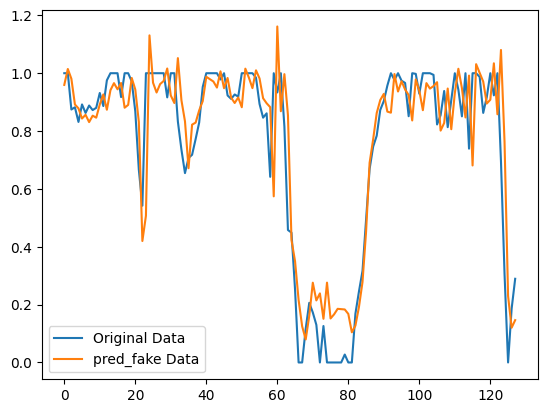

In [7]:
# visualize
X = next(iter(dl_test))
pred_y_ori = model_ori(X[:,:23, :]).detach().cpu().squeeze()
pred_y_fake = model_fake(X[:,:23, :]).detach().cpu().squeeze()
true_y = X[:,23,0]

plt.figure()
plt.plot(true_y.numpy(), label='Original Data')
# plt.plot(pred_y_ori.numpy(), label='pred_Original Data')
plt.plot(pred_y_fake.numpy(), label='pred_fake Data')
plt.legend()
plt.show()
